In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import mlfinlab as ml

%matplotlib inline

3.1 Form dollar bars for E-mini S&P 500 futures:

(a) Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).

(b) Use Snippet 3.4 on a pandas series t1, where numDays=1.

(c) On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.

(d) Apply getBins to generate the labels.


(a) Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns

In [ ]:
dollar_bar = pd.read_parquet("./data/processed/ml_SP500_dollar_bar.parq")
dollar_bar

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2009-09-28 09:46:35,64,50.79,51.070,50.710,51.070,20044,13464,64,1.020582e+06
1,2009-09-28 09:53:49,116,51.07,51.150,51.050,51.130,19724,15474,52,1.007758e+06
2,2009-09-28 09:54:40,148,51.14,51.140,51.129,51.140,20051,12751,32,1.025308e+06
3,2009-09-28 10:00:38,205,51.14,51.210,51.080,51.210,19736,14247,57,1.009192e+06
4,2009-09-28 10:02:52,247,51.21,51.260,51.200,51.260,19554,17754,42,1.002096e+06
...,...,...,...,...,...,...,...,...,...,...
157816,2022-08-25 15:57:52,6749725,148.49,148.560,148.485,148.540,6901,3901,39,1.024920e+06
157817,2022-08-25 15:58:30,6749759,148.54,148.540,148.510,148.520,6830,1300,34,1.014422e+06
157818,2022-08-25 15:59:17,6749803,148.52,148.580,148.520,148.550,6899,3852,44,1.024832e+06
157819,2022-08-25 15:59:50,6749848,148.55,148.595,148.540,148.595,6982,3081,45,1.037241e+06


In [ ]:
def get_close(doll_bar):
  close = pd.Series(data = dollar_bar["close"])
  index = dollar_bar["date_time"].squeeze()
  close.index = index
  # prepare close price without duplicate index
  close = close[~close.index.duplicated(keep='first')]
  return close


In [ ]:
close = get_close(dollar_bar)
close


date_time
2009-09-28 09:46:35     51.070
2009-09-28 09:53:49     51.130
2009-09-28 09:54:40     51.140
2009-09-28 10:00:38     51.210
2009-09-28 10:02:52     51.260
                        ...   
2022-08-25 15:57:52    148.540
2022-08-25 15:58:30    148.520
2022-08-25 15:59:17    148.550
2022-08-25 15:59:50    148.595
2022-08-25 16:00:00    148.620
Name: close, Length: 155055, dtype: float64

In [ ]:
daily_vol = ml.util.volatility.get_daily_vol(close)

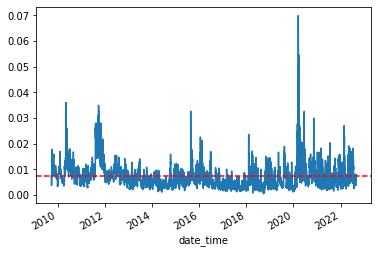

In [ ]:
f, ax = plt.subplots()
daily_vol.plot(ax=ax)
mean = daily_vol.mean()
ax.axhline(float(daily_vol.mean()), ls = '--', color='r')

(b) Use Snippet 3.4 on a pandas series t1, where numDays=1.

In [ ]:
daily_vol = ml.util.volatility.get_daily_vol(close)
cumsum_events = ml.filters.cusum_filter(close, threshold=float(daily_vol.mean()))
vertical_barriers = ml.labeling.labeling.add_vertical_barrier(t_events=cumsum_events, close=close, num_days=1)


(c) On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.

In [ ]:
triple_barrier_events = (ml.labeling.get_events(close = close,
                                                t_events=cumsum_events,
                                                pt_sl=[1,1],
                                                target=daily_vol,
                                                min_ret=0.005,
                                                num_threads=1,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=None))
triple_barrier_events

c:\users\user\appdata\local\programs\python\python310\lib\site-packages\mlfinlab\util\multiprocess.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


,t1,trgt,pt,sl
2009-09-29 10:02:46,2009-09-30 09:52:49,0.007057,1,1
2009-09-30 09:52:49,2009-09-30 13:07:21,0.005569,1,1
2009-09-30 12:41:33,2009-10-01 09:52:41,0.007981,1,1
2009-09-30 15:16:01,2009-10-01 10:00:31,0.007721,1,1
2009-10-01 09:43:43,2009-10-01 11:13:48,0.007731,1,1
...,...,...,...,...
2022-08-12 15:50:11,2022-08-15 09:30:00,0.005139,1,1
2022-08-15 11:52:01,2022-08-16 11:56:33,0.006625,1,1
2022-08-22 14:07:16,2022-08-23 14:11:54,0.006582,1,1
2022-08-24 09:30:59,2022-08-25 09:30:00,0.006629,1,1


(d) Apply getBins to generate the labels.

In [ ]:
labels = ml.labeling.get_bins(triple_barrier_events, close)
print(labels)
print(labels.bin.value_counts())

                          ret      trgt  bin
2009-09-29 10:02:46 -0.009319  0.007057   -1
2009-09-30 09:52:49  0.008622  0.005569    1
2009-09-30 12:41:33 -0.008009  0.007981   -1
2009-09-30 15:16:01 -0.008201  0.007721   -1
2009-10-01 09:43:43 -0.009052  0.007731   -1
...                       ...       ...  ...
2022-08-12 15:50:11 -0.005874  0.005139   -1
2022-08-15 11:52:01  0.007311  0.006625    1
2022-08-22 14:07:16 -0.002403  0.006582    0
2022-08-24 09:30:59  0.007158  0.006629    1
2022-08-25 09:46:17  0.006926  0.006774    1

[4655 rows x 3 columns]
 0    1625
 1    1554
-1    1476
Name: bin, dtype: int64


3.2 From exercise 1, use Snippet 3.8 to drop rare labels

In [ ]:
clean_labels = ml.labeling.drop_labels(labels, min_pct=0.05)
clean_labels.bin.value_counts()

 0    1625
 1    1554
-1    1476
Name: bin, dtype: int64

3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.

In [ ]:
labels = ml.labeling.get_bins(triple_barrier_events, close)
print(labels)
print(labels.bin.value_counts())

                          ret      trgt  bin
2009-09-29 10:02:46 -0.009319  0.007057   -1
2009-09-30 09:52:49  0.008622  0.005569    1
2009-09-30 12:41:33 -0.008009  0.007981   -1
2009-09-30 15:16:01 -0.008201  0.007721   -1
2009-10-01 09:43:43 -0.009052  0.007731   -1
...                       ...       ...  ...
2022-08-12 15:50:11 -0.005874  0.005139   -1
2022-08-15 11:52:01  0.007311  0.006625    1
2022-08-22 14:07:16 -0.002403  0.006582    0
2022-08-24 09:30:59  0.007158  0.006629    1
2022-08-25 09:46:17  0.006926  0.006774    1

[4655 rows x 3 columns]
 0    1625
 1    1554
-1    1476
Name: bin, dtype: int64


3.4 Develop moving average crossover strategy. For each obs. the model suggests a side but not size of the bet

In [ ]:
fast_window = 3
slow_window = 7
close = get_close(dollar_bar)
close_df = (pd.DataFrame()\
            .assign(price=close)\
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean())).dropna()

print(close_df)

                       price        fast        slow
date_time                                           
2009-09-28 09:46:35   51.070   51.070000   51.070000
2009-09-28 09:53:49   51.130   51.104286   51.102000
2009-09-28 09:54:40   51.140   51.119730   51.116391
2009-09-28 10:00:38   51.210   51.152743   51.144667
2009-09-28 10:02:52   51.260   51.187900   51.174264
...                      ...         ...         ...
2022-08-25 15:57:52  148.540  148.438171  148.359878
2022-08-25 15:58:30  148.520  148.458628  148.379893
2022-08-25 15:59:17  148.550  148.481471  148.401157
2022-08-25 15:59:50  148.595  148.509853  148.425387
2022-08-25 16:00:00  148.620  148.537390  148.449714

[155055 rows x 3 columns]


In [ ]:
def get_up_cross(df):
  crit1 = df.fast.shift(1) < df.slow.shift(1)
  crit2 = df.fast > df.slow
  return df.fast[crit1 & crit2]

def get_down_cross(df):
  crit1 = df.fast.shift(1) > df.slow.shift(1)
  crit2 = df.fast < df.slow
  return df.fast[crit1 & crit2]

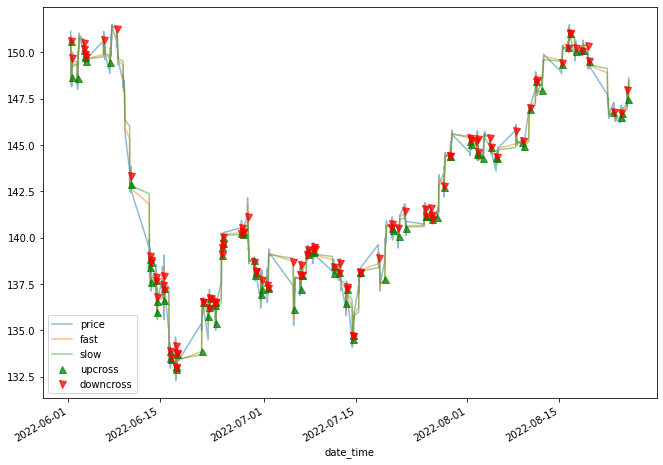

In [ ]:
close_df = close_df[~close_df.index.duplicated(keep='first')]
up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11, 8))
close_df.loc['2022-06':].plot(ax=ax, alpha=0.5)
up.loc['2022-06':].plot(ax=ax, ls='', marker='^', markersize=7, alpha=0.75, label='upcross', color='g')
down.loc['2022-06':].plot(ax=ax, ls='', marker='v', markersize=7, alpha=0.75, label='downcross', color='r')

ax.legend()

3.4 (a) Derive meta-labels for ptSl=[1,2] and t1 where numDays=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

In [ ]:
side_up = pd.Series(1, index=up.index) 
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up, side_down]).sort_index()

In [ ]:
# remove close price that does not exist in close_df
close = pd.Series(data = close_df.price, index = close_df.index)

In [ ]:
daily_vol = ml.util.volatility.get_daily_vol(close)
target = daily_vol[side.index.intersection(daily_vol.index)]

cumsum_events = ml.filters.cusum_filter(close, threshold=float(daily_vol.mean()))
vertical_barriers = ml.labeling.labeling.add_vertical_barrier(t_events=cumsum_events, close=close, num_days=1)
triple_barrier_events = (ml.labeling.get_events(close = close,
                                                t_events=cumsum_events,
                                                pt_sl=[1,2],
                                                target=daily_vol,
                                                min_ret=0.01,
                                                num_threads=1,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=side))
triple_barrier_events


c:\users\user\appdata\local\programs\python\python310\lib\site-packages\mlfinlab\util\multiprocess.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


,t1,trgt,side,pt,sl
2009-10-02 09:31:45,2009-10-05 09:51:42,0.010181,NaN,1,2
2009-10-02 10:35:07,2009-10-05 09:51:42,0.010237,NaN,1,2
2009-10-05 14:44:31,2009-10-06 15:08:51,0.013427,NaN,1,2
2009-10-06 09:50:11,2009-10-07 10:01:38,0.016744,NaN,1,2
2009-10-06 14:15:42,2009-10-07 14:31:11,0.017614,NaN,1,2
...,...,...,...,...,...
2022-07-18 15:34:06,2022-07-19 15:37:18,0.012293,NaN,1,2
2022-07-19 09:30:05,2022-07-19 14:07:56,0.012483,1.0,1,2
2022-07-19 11:03:11,2022-07-20 11:12:53,0.011333,NaN,1,2
2022-07-19 15:42:23,2022-07-20 15:45:21,0.010322,NaN,1,2


In [ ]:
triple_barrier_events.side.value_counts()

 1.0    130
-1.0    127
Name: side, dtype: int64

In [ ]:
labels = ml.labeling.get_bins(triple_barrier_events.dropna(), close)
print(labels)
print(labels.bin.value_counts())

                          ret      trgt  bin  side
2009-11-02 09:59:56 -0.001407  0.014782    0   1.0
2009-11-02 12:11:29  0.015918  0.015531    1  -1.0
2009-11-04 14:29:49 -0.009116  0.011206    0  -1.0
2010-02-09 09:32:55  0.000879  0.014393    0   1.0
2010-02-09 11:17:29 -0.002539  0.013639    0  -1.0
...                       ...       ...  ...   ...
2022-05-19 11:46:29 -0.010551  0.014579    0   1.0
2022-05-19 15:32:34  0.013994  0.013742    1  -1.0
2022-05-24 09:30:00 -0.004946  0.013189    0  -1.0
2022-06-15 14:04:39  0.012823  0.010040    1  -1.0
2022-07-19 09:30:05  0.013548  0.012483    1   1.0

[257 rows x 4 columns]
0    170
1     87
Name: bin, dtype: int64


3.4 (b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {−1,1}.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [ ]:
side = triple_barrier_events.dropna().side

              precision    recall  f1-score   support

           0       0.60      1.00      0.75        78
           1       0.00      0.00      0.00        51

    accuracy                           0.60       129
   macro avg       0.30      0.50      0.38       129
weighted avg       0.37      0.60      0.46       129



c:\users\user\appdata\local\programs\python\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

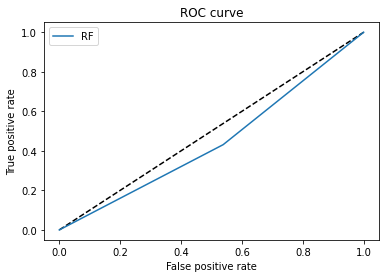

In [ ]:
X = side.values.reshape(-1,1)
y = labels.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator, criterion='entropy', random_state=0)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:,1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0,1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['no_trade', 'trade']))

              precision    recall  f1-score   support

    no_trade       0.60      1.00      0.75        78
       trade       0.00      0.00      0.00        51

    accuracy                           0.60       129
   macro avg       0.30      0.50      0.38       129
weighted avg       0.37      0.60      0.46       129



c:\users\user\appdata\local\programs\python\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

In [ ]:
def bb_bands(price, window=None, width=None, numsd=None):
  ''' returns average, upper band, and lower band
  '''
  ave = price.rolling(window).mean()
  sd = price.rolling(window).std(ddof=0)
  if width:
    upband = ave * (1 + width)
    dnband = ave * (1 - width)
    return price, np.round(ave, 6), np.round(upband, 6), np.round(dnband, 6)
  if numsd:
    upband = ave + numsd * sd
    dnband = ave - numsd * sd
    return price, np.round(ave, 6), np.round(upband, 6), np.round(dnband, 3)


In [ ]:
window = 50
bb_df = pd.DataFrame()
bb_df['price'], bb_df['ave'], bb_df['upper'], bb_df['lower'] = bb_bands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
print(bb_df)

                       price         ave       upper    lower
date_time                                                    
2009-09-29 15:09:13   51.670   51.462060   51.636720   51.287
2009-09-29 15:31:13   51.545   51.471560   51.637328   51.306
2009-09-29 15:45:07   51.560   51.480160   51.638994   51.321
2009-09-29 15:57:02   51.500   51.487360   51.638589   51.336
2009-09-30 09:31:59   51.660   51.496360   51.644167   51.349
...                      ...         ...         ...      ...
2022-08-25 15:57:52  148.540  148.025204  148.297366  147.753
2022-08-25 15:58:30  148.520  148.041404  148.318386  147.764
2022-08-25 15:59:17  148.550  148.057804  148.340087  147.776
2022-08-25 15:59:50  148.595  148.075304  148.363170  147.787
2022-08-25 16:00:00  148.620  148.092504  148.386641  147.798

[155006 rows x 4 columns]


<AxesSubplot:xlabel='date_time'>

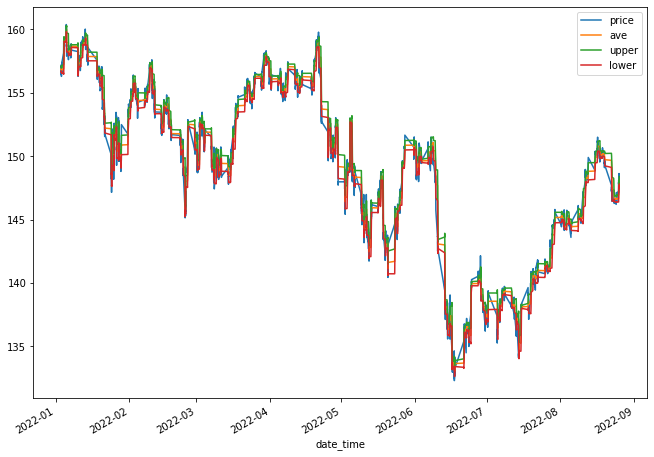

In [ ]:
f, ax = plt.subplots(figsize=(11, 8))
bb_df.loc['2022'].plot(ax=ax)

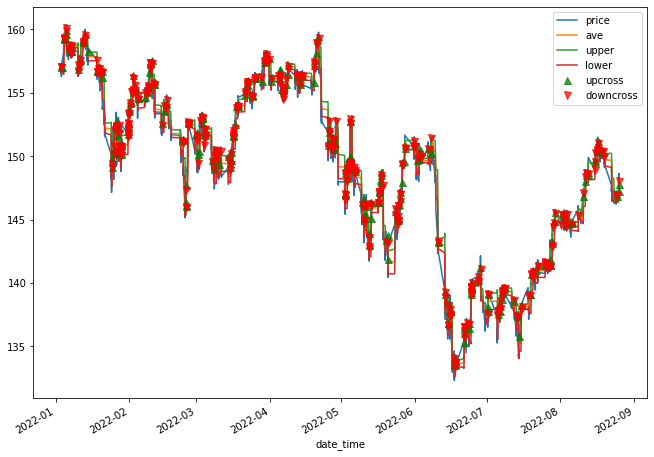

In [ ]:
def get_up_cross(df, col):
  # col is price column
  crit1 = df[col].shift(1) < df.upper.shift(1)
  crit2 = df[col] > df.upper
  return df[col][crit1 & crit2]

def get_down_cross(df, col):
  # col is price column
  crit1 = df[col].shift(1) > df.upper.shift(1)
  crit2 = df[col] < df.upper
  return df[col][crit1 & crit2]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price')

f, ax = plt.subplots(figsize=(11,8))
bb_df.loc['2022':].plot(ax=ax)
bb_up.loc['2022':].plot(ax=ax, ls='', marker='^', markersize=7, alpha=0.75, label='upcross', color='g')
bb_down.loc['2022':].plot(ax=ax, ls='', marker='v', markersize=7, alpha=0.75, label='downcross', color='r')
ax.legend()

3.5 (a) Derive meta-labels for ptSl=[0,2] and t1 where numDays=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

In [ ]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up, bb_side_down]).sort_index()
print(bb_side_raw)

date_time
2009-09-29 15:31:13    1
2009-09-30 09:31:59   -1
2009-09-30 09:43:53    1
2009-10-05 10:53:31   -1
2009-10-07 09:48:19    1
                      ..
2022-08-24 15:21:43   -1
2022-08-24 15:59:23    1
2022-08-25 09:30:00   -1
2022-08-25 10:52:26    1
2022-08-25 15:02:46   -1
Length: 10712, dtype: int64


In [ ]:
side = bb_side_raw[~bb_side_raw.index.duplicated(keep='first')]

In [ ]:
daily_vol = ml.util.volatility.get_daily_vol(close)
target = daily_vol[side.index]

cumsum_events = ml.filters.cusum_filter(close, threshold=float(daily_vol.mean()))
vertical_barriers = ml.labeling.labeling.add_vertical_barrier(t_events=cumsum_events, close=close, num_days=1)
triple_barrier_events = (ml.labeling.get_events(close = close,
                                                t_events=cumsum_events,
                                                pt_sl=[0,2],
                                                target=daily_vol,
                                                min_ret=0.01,
                                                num_threads=1,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=side))


c:\users\user\appdata\local\programs\python\python310\lib\site-packages\mlfinlab\labeling\labeling.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profit_taking = pd.Series(index=events.index)  # NaNs
c:\users\user\appdata\local\programs\python\python310\lib\site-packages\mlfinlab\util\multiprocess.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


In [ ]:
labels = ml.labeling.get_bins(triple_barrier_events.dropna(), close)
print(labels)
print(labels.bin.value_counts())


                          ret      trgt  bin  side
2009-10-12 09:30:09  0.004042  0.010988    1  -1.0
2009-10-30 09:33:56 -0.017444  0.013599    0   1.0
2009-11-04 14:19:50  0.006583  0.011390    1   1.0
2009-11-04 14:29:49  0.009200  0.011206    1   1.0
2010-02-09 12:00:45  0.003333  0.013041    1  -1.0
...                       ...       ...  ...   ...
2022-01-27 09:30:00  0.011268  0.010832    1  -1.0
2022-05-24 14:09:29 -0.005994  0.011850    0  -1.0
2022-06-15 14:00:31  0.033044  0.010043    1  -1.0
2022-06-15 15:44:17 -0.021931  0.010886    0   1.0
2022-06-28 09:30:05  0.020515  0.010433    1  -1.0

[263 rows x 4 columns]
0    141
1    122
Name: bin, dtype: int64


In [ ]:
def returns(s):
  arr = np.diff(np.log(s))
  return pd.Series(arr, index=s.index[1:])

def df_rolling_autocorr(df, window, lag=1):
  ''' Computer rolling column-wise autocorrelation for a Dataframe'''
  return df.rolling(window=window).corr(df.shift(lag)).dropna()

In [ ]:
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')
print(srl_corr)

date_time
2009-09-29 15:45:07   -0.521743
2009-09-29 15:57:02   -0.521729
2009-09-30 09:31:59   -0.528646
2009-09-30 09:43:53   -0.559515
2009-09-30 09:52:49   -0.358027
                         ...   
2022-08-25 15:57:52    0.100193
2022-08-25 15:58:30    0.084072
2022-08-25 15:59:17    0.079730
2022-08-25 15:59:50    0.083573
2022-08-25 16:00:00    0.090437
Name: srl_corr, Length: 155004, dtype: float64


In [ ]:
side = triple_barrier_events.dropna().side

              precision    recall  f1-score   support

           0       0.53      0.70      0.60        70
           1       0.46      0.29      0.36        62

    accuracy                           0.51       132
   macro avg       0.49      0.50      0.48       132
weighted avg       0.50      0.51      0.49       132



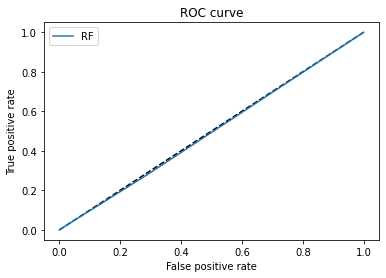

In [ ]:
X = side.values.reshape(-1,1)
y = labels.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator, criterion='entropy', random_state=0)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:,1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0,1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

3.5 (d) What is the accuracy of predictions from the primary model (i.e., if the secondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [ ]:
print(classification_report(y_test, y_pred, target_names=['no_trade', 'trade']))


              precision    recall  f1-score   support

    no_trade       0.53      0.70      0.60        70
       trade       0.46      0.29      0.36        62

    accuracy                           0.51       132
   macro avg       0.49      0.50      0.48       132
weighted avg       0.50      0.51      0.49       132

